# Distributed Inference

In [4]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
import tensorflow as tf
import tensorflow_probability as tfp
import os, sys, subprocess
import numpy as np

import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
%matplotlib inline

In [10]:
sys.path.append('../')
sys.path.append('../..')
from src.generate_data import generate_data_from_signal, generate_grouped_data, generate_series, sample_prior, generate_theta, generate_alternate_series
from src.posterior_samplers import posterior_sample, wasserstein_coefs, normal_sampler

## Generate Data

In [7]:
# Params
n=200
m=40
sig=1
tau=1
alpha=1.5
beta = 1.5
num_coef = 100

In [8]:
signal = generate_theta(num_coeff=num_coef)
observations = generate_grouped_data(signal, n=n, sig=sig, m=m)

In [38]:
len(observations[1])

100

In [20]:
list_of_obs = [Y for X,Y in [generate_alternate_series(observations[i]) for i in range(len(observations))]]

In [17]:
def list_of_arrary_to_df(list_of_array, 
                         type_col='Simulated', 
                         list_index = 'index',
                         inter_list_index='observation'):
    
    all_obs = pd.DataFrame.from_records(list_of_array)
    stacked_obs = all_obs.reset_index().set_index('index').stack().reset_index()

    stacked_obs.columns = [inter_list_index, list_index, 'value']

    stacked_obs['type'] = type_col
    
    return stacked_obs

In [21]:
stacked_obs = list_of_arrary_to_df(list_of_obs, list_index='time_index')

In [10]:
stacked_obs.head(5)

,observation,time_index,value,type
0,0,0,23.522503,Simulated
1,0,1,0.258654,Simulated
2,0,2,0.302417,Simulated
3,0,3,0.884968,Simulated
4,0,4,1.058265,Simulated


In [22]:
signal_df = pd.DataFrame({'value': generate_alternate_series(signal)[1], 'time_index' : [i for i in np.arange(len(signal))]})
signal_df['type'] = 'True'

In [12]:
signal_df.head(5)

,value,time_index,type
0,0.549754,0,True
1,0.501760,1,True
2,0.462692,2,True
3,0.436946,3,True
4,0.414753,4,True


In [23]:
plot_df = pd.concat([stacked_obs[['time_index','value', 'type']], signal_df], sort=True).reset_index()

In [14]:
plot_df['time'] = plot_df['time_index']/num_coef

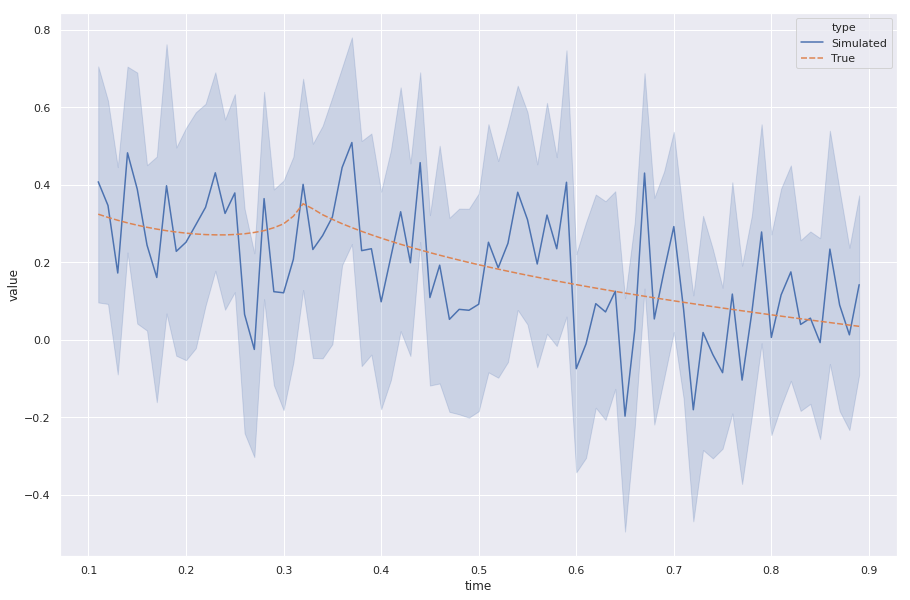

In [15]:
a4_dims = (15, 10)
fig, ax = plt.subplots(figsize=a4_dims)
plot_df_reduced = plot_df.loc[(plot_df.time_index > 10) & (plot_df.time_index <90),:]
# Plot the responses for different events and regions
sns.lineplot(x="time", y='value', hue='type', data=plot_df_reduced, ax=ax, style='type')

## Sequential graph

In [18]:
post_mean = tf.reduce_mean([posterior_sample(observations[i], n, m, sig, tau, alpha) for i in range(m)],0)

/home/bobby/.local/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/bobby/.local/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/bobby/.local/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/bobby/.local/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/bobby/.local/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is de

In [19]:
post_mean

<tf.Tensor 'Mean:0' shape=(100,) dtype=float64>

In [13]:
wass_bary_temp = [wasserstein_coefs(observations[i], n, sig, alpha) for i in range(m)] 
wass_bary_coefs = np.mean(wass_bary_temp,0)
wass_bary_sample = normal_sampler(wass_bary_coefs[0,], wass_bary_coefs[1,])

/home/bobby/.local/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/bobby/.local/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/bobby/.local/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/bobby/.local/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)
/home/bobby/.local/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is de

In [14]:
wass_bary_sample

<tf.Tensor 'MultivariateNormalDiag_1/sample/affine_linear_operator/forward/add:0' shape=(100,) dtype=float64>

In [15]:
nsim = 2000
results = [None] * nsim
break_div = np.floor_divide(nsim,10)
with tf.Session() as sess: 
    for i in range(nsim):
        results[i] = sess.run(wass_bary_sample)
        
        if i % break_div == 0:
            print("Iteration {0} of {1}".format(i, nsim))

Iteration 0 of 2000
Iteration 200 of 2000
Iteration 400 of 2000
Iteration 600 of 2000
Iteration 800 of 2000
Iteration 1000 of 2000
Iteration 1200 of 2000
Iteration 1400 of 2000
Iteration 1600 of 2000
Iteration 1800 of 2000


### Look at results

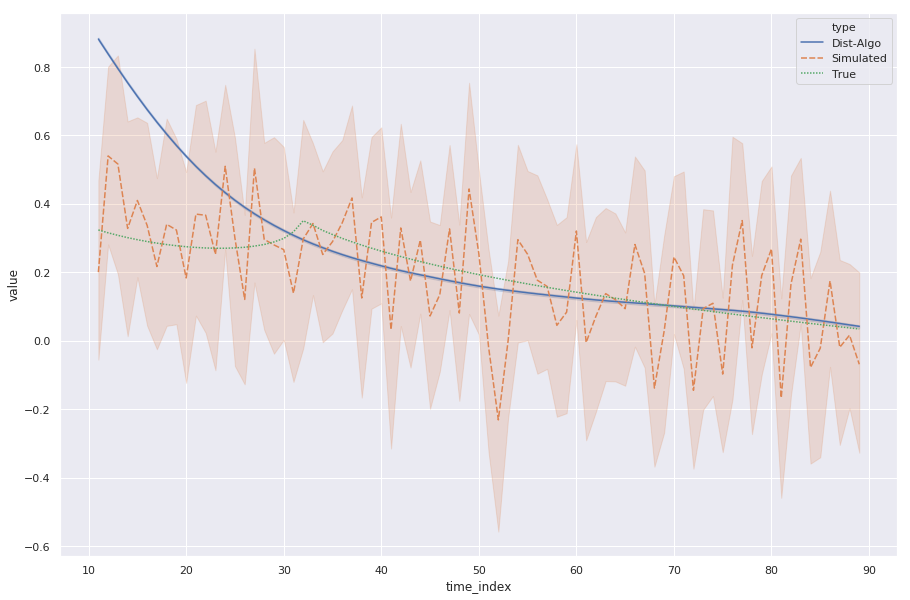

In [24]:
list_of_post = [Y for X,Y in [generate_alternate_series(results[i]) for i in range(len(results))]]
stacked_post = list_of_arrary_to_df(list_of_post, list_index='time_index', type_col='Dist-Algo')

plot_df2 = pd.concat([stacked_post[['time_index','value', 'type']], plot_df], sort=True)\
.reset_index()
plot_df3 = plot_df2.loc[(plot_df2.time_index > 10) & (plot_df2.time_index <90),:]

a4_dims = (15, 10)
fig, ax = plt.subplots(figsize=a4_dims)

# Plot the responses for different events and regions
sns.lineplot(x="time_index", y='value', hue='type', data=plot_df3, ax=ax, style='type')

## Build Distributed graph

First set up worker compute nodes for tasks 0,1 etc. using commands below from scripts directory in separate processes i.e. from separate terminals or as background processes:

- python create_worker.py --ps_hosts=localhost:2222 --worker_hosts=localhost:2223,localhost:2224 --job_name=worker --task_index=0 &
- python create_worker.py --ps_hosts=localhost:2222 --worker_hosts=localhost:2223,localhost:2224 --job_name=worker --task_index=1 &

Or use bash script from the scripts directory:
- sh -x bash.sh

In [15]:
ps_hosts=["localhost:2222"]
worker_hosts=["localhost:2223","localhost:2224"]
cluster = tf.train.ClusterSpec({"ps": ps_hosts, "worker": worker_hosts})

In [16]:
server = tf.train.Server(cluster,
                             job_name='ps',
                             task_index=0)

In [17]:
with tf.device("/job:worker/task:0"):
    posterior1 = posterior_sample(observations[0], n, m, sig, tau, alpha)
    
with tf.device("/job:worker/task:1"):
    posterior2 = posterior_sample(observations[1], n, m, sig, tau, alpha)

    samp = (posterior1 + posterior2)/2
    

In [18]:
nsim = 2000
results = [None] * nsim
break_div = np.floor_divide(nsim,10)
with tf.Session("grpc://localhost:2223") as sess: 
    for i in range(nsim):
        results[i] = sess.run(samp)
        
        if i % break_div == 0:
            print("Iteration {0} of {1}".format(i, nsim))

Iteration 0 of 2000
Iteration 200 of 2000
Iteration 400 of 2000
Iteration 600 of 2000
Iteration 800 of 2000
Iteration 1000 of 2000
Iteration 1200 of 2000
Iteration 1400 of 2000
Iteration 1600 of 2000
Iteration 1800 of 2000


### Look at results

In [ ]:
list_of_post = [Y for X,Y in [generate_series(results[i]) for i in range(len(results))]]
stacked_post = list_of_arrary_to_df(list_of_post, list_index='time_index', type_col='Dist-Algo')

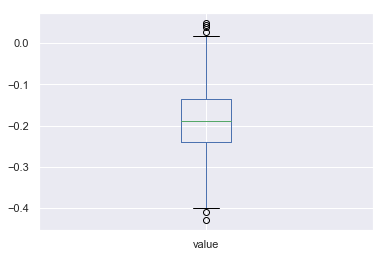

In [78]:
stacked_post.loc[stacked_post.time_index == 50,['value']].boxplot()

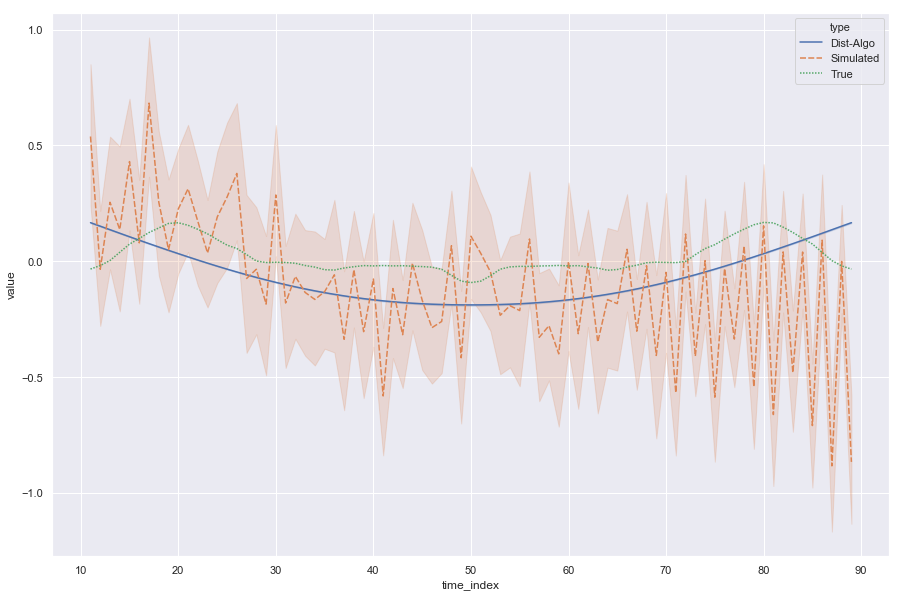

In [74]:
plot_df2 = pd.concat([stacked_post[['time_index','value', 'type']], plot_df], sort=True)\
.reset_index()

rview = (plot_df2.time_index > 10) & (plot_df2.time_index <90)# & (plot_df2.type=='Dist-Algo')
plot_df3 = plot_df2.loc[rview,:]

a4_dims = (15, 10)
fig, ax = plt.subplots(figsize=a4_dims)

# Plot the responses for different events and regions
sns.lineplot(x="time_index", y='value', hue='type', data=plot_df3, ax=ax, style='type', err_style = 'band')
